In [1]:
from IPython.display import Math
Math(rf'0.1d+20+0.5b')

<IPython.core.display.Math object>

In [2]:
from modeling.compute import Par

In [3]:
p1, p2 = Par(1, 'km'), Par()
p1.varunit, p2.varval, p1+p2

(1 <Unit('kilometer')>, None, p0 + p1)

### Restructuring

In [4]:
from modeling.compute import Par, Var, Model, RefNode, adda, addf

In [5]:
model = Model()
m = RefNode(name='/', ref=model)
a = Var('a')
e = Var('e')
p = Par('p', 0.1)
x = adda(m, 'x', 0.5*a)
b = adda(m, 'b', x+0.5)
d = Var('d')
c = adda(m, 'c', p*d+20+0.5*b)
adda(m, d, c-10)
addf(m, d+0.5*e, nameasidx=True);

In [6]:
eeqs, eqv, dout, dins = model.data_structures()

In [6]:
from graph.operators import eqv_to_edges_tree
from graph.matrixview import render_incidence

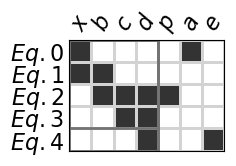

In [7]:
edges, tree, _ = eqv_to_edges_tree(eqv, output_set=dout, offset=False) 
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

### Restructure by matching

In [8]:
from graph.graphview import bipartite_repr
from trash.inputresolver import mdf_order
import networkx as nx

In [45]:
B, edges_B = bipartite_repr(eqv)
M = nx.bipartite.maximum_matching(B)

In [10]:
doutM = {key:M[key] for key in dout.keys()} 
#doutM = {0: x, 1: b, 2: d, 3: c, 4: e} hard coded solution

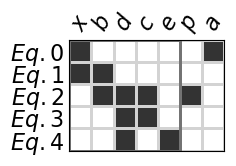

In [11]:
edges, tree, _ = eqv_to_edges_tree(eqv, output_set=doutM, offset=False) 
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

In [13]:
mdf_order(eqv, dout) # should get [0, 1, (3, 2), 4]

[0, 1, (3, 2)]

### Restructure by extended tearing

In [1]:
from compute import Par, Var, Model, adda, addf, Expcomp, Evaluable
from inputresolver import idx_eqlist, mdf_order, resolve, getallvars, invert_edges, reassign
from representations import bipartite_repr, digraph_repr
from notationcompute import optsolver, solver, explicit

### Let's try to reassign all

In [10]:
mdf_order(eqv, dout)

[0, 1, (3, 2), 4]

### Let's try to avoid loop

### New library

In [30]:
from presolver.tearing import min_arc_set_assign
from graph.operators import invert_edges,default_tree
from graph.graphutils import all_variables, all_edges

In [23]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)

In [25]:
xsol, model = min_arc_set_assign(edges_left_right, varidxs, eqnidxs)
outset_minassign = dict((right, left) for left, right in edges_left_right if xsol[left, right] > 0.5)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2527862
Academic license 2527862 - for non-commercial use only - registered to no___@mit.edu
Set parameter WLSSecret
Set parameter LicenseID to value 2527862
Academic license 2527862 - for non-commercial use only - registered to no___@mit.edu


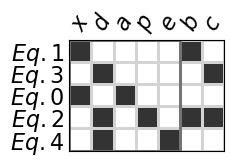

In [33]:
edges = invert_edges(eqv, newout=outset_minassign)
tree = default_tree(mdf_order(eqv, outset_minassign))
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

### Old library

In [67]:
from trash.inputresolver import getallvars, invert_edges, resolve, reassign

In [43]:
vrs =getallvars(eqs)-{None}

In [62]:
sol = resolve(eqs, vrs, invert_edges(edges_B), maxiter=2, not_input=[d, b, x, c])
newdout = dict(sol[-1]['SOL'])
# possible solution newdout = {0: a, 1: x, 2: b, 3: c, 4: d}

In [63]:
newdout, dout

({0: a, 1: x, 2: b, 3: c, 4: d}, {0: x, 1: b, 2: c, 3: d, 4: None})

In [65]:
mdf_order(eqv, newdout)

[4, 3, 2, 1, 0]

In [68]:
eqsn = reassign(eqs, newdout)

In [69]:
eqsn

{0: (a, 2.0*x),
 1: (x, b - 0.5),
 2: (b, -2.0*p*d + 2.0*c - 40.0),
 3: (c, d + 10),
 4: (d, -0.5*e)}

# 2. Execution workflow 1

In [74]:
import openmdao.api as om
from trash.notationcompute import optsolver, solver, explicit
# import networkx as nx
# import sympy as sp

In [71]:
#mapping = {'solver':solver, 'exp':explicit}

In [75]:
prob = om.Problem()
model = prob.model
groups = {0:model}

In [81]:
explicit(groups, eqsn, 0, d, 4)
explicit(groups, eqsn, 0, c, 3)
explicit(groups, eqsn, 0, b, 2)
explicit(groups, eqsn, 0, x, 1)
explicit(groups, eqsn, 0, a, 0)

KeyError: '4'

In [21]:
f = Var('f')
#explicit(groups, {5: (None, a**2+d**2)}, 0, f, 5)

In [22]:
optsolver(groups, {5: (None, a**2+d**2+b**2)}, 0, 1, [e], [[],[],[5]])

In [23]:
prob.setup();

In [24]:
#om.n2(model)

In [25]:
eqsn

{0: (a, 2.0*x),
 1: (x, b - 0.5),
 2: (b, 2.0*c - 0.2*d - 40.0),
 3: (c, d + 10),
 4: (d, -0.5*e)}

In [26]:
#prob.set_val('c', 100)
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: [121.17674419]
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


In [27]:
model.list_inputs();

9 Input(s) in 'model'

varname  val           
-------  --------------
eq4
  e      [-21.34883721]
eq3
  d      [10.6744186]  
eq2
  d      [10.6744186]  
  c      [20.6744186]  
eq1
  b      [-0.78604651] 
eq0
  x      [-1.28604651] 
eq5
  b      [-0.78604651] 
  d      [10.6744186]  
  a      [-2.57209302] 




In [28]:
prob.set_val('e', -21.35)
prob.run_model()
prob.get_val('f05'), prob.get_val('e')

(array([121.17675]), array([-21.35]))

### Execution workflow 2

In [33]:
prob = om.Problem()
model = prob.model
groups = {0:model}

## TODO
Need to exchange the numbers with the expressions probably to make the interface cleaner and independent of passing in the eqs var

In [34]:
solver(groups, eqs, 0, 1, [a], [4])
explicit(groups, eqs, 1, x, 0)
explicit(groups, eqs, 1, b, 1)
solver(groups, eqs, 1, 2, [c,d], [2,3])
optsolver(groups, {5: (None, a**2+d**2+b**2)}, 0, 1, [e], [[],[],[5]])

In [35]:
prob.setup();

In [37]:
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
prob.run_driver();


group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 1 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 0 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [121.17674419]
            Iterations: 2
            Function eva

In [36]:
# prob.set_val('e', -21.35)
# prob.run_model()
# prob.get_val('f05')

### 4. Additional workflow testing

In [18]:
import sympy as sp
import openmdao.api as om
from trash.notationcompute import optsolver, solver, explicit

In [19]:
eqs = {
    0: (a, x**2-2*x),
    1: (None, a+sp.sin(x)-1),
    2: (None, -x+2)
}

In [20]:
groups = {}

In [25]:
prob = om.Problem()
model = prob.model
groups[0] = model

In [26]:
solver(groups, eqs, 0, 1, [x], [1]) #groups, eqs, parentid, childid, solvevars, res, 
explicit(groups, eqs, 1, a, 0)
#optsolver(0, 1, [x], [[2],[],[1]])
#prob.driver = om.ScipyOptimizeDriver()
#prob.run_driver();

In [27]:
prob.setup();

In [28]:
prob.set_solver_print(level=1)
prob.run_model()


group1
NL: Newton Converged in 6 iterations


In [29]:
model.list_outputs();

1 Explicit Output(s) in 'model'

varname  val         
-------  ------------
group1
  eq0
    a    [0.11550053]


1 Implicit Output(s) in 'model'

varname  val         
-------  ------------
group1
  res1
    x    [2.05617258]




### OpenMDAO interface v2

In [ ]:
group = parent.add_subsystem('group{}'.format(counter), 
        om.Group(), promotes=['*'])
cmp = Impcomp(output_names=['a','x'], equations=eqs(3,4))
parent.add_subsystem("eq{}".format(eqn), cmp)
cmp = Expcomp(output_name='b', equations=eq(0))
parent.add_subsystem("eq{}".format(eqn), cmp)
group = parent.add_subsystem('group{}'.format(counter), 
        om.Group(), promotes=['*'])
cmp = Impcomp(output_names=['c','d'], equations=eqs(1,2))

In [ ]:
g = prob.add
bal = BalanceComp()

bal.add_balance('c', val=1.0)
bal.add_balance('d', val=1.0)
prob.model.add_subsystem(name='balance', subsys=bal, promotes=['*'])

for eqn in [2,3]:
    parent.add_subsystem("eq{}".format(eqn), Expcomp(
                            output_name='r{}'.format(eqn),
                            equation=equationcreator(right-left),
                            debug=debug), 
                            promotes=['*'])
prob.model.connect('exec.y', 'balance.lhs:x')
prob.model.linear_solver = DirectSolver()
prob.model.nonlinear_solver = NewtonSolver(solve_subsystems=False)
prob.setup()
prob.set_val('exec.x', 2)
prob.run_model()